
0: 448x640 1 dog, 285.8ms
Speed: 15.6ms preprocess, 285.8ms inference, 15.7ms postprocess per image at shape (1, 3, 448, 640)


Probability:  0.29086679220199585


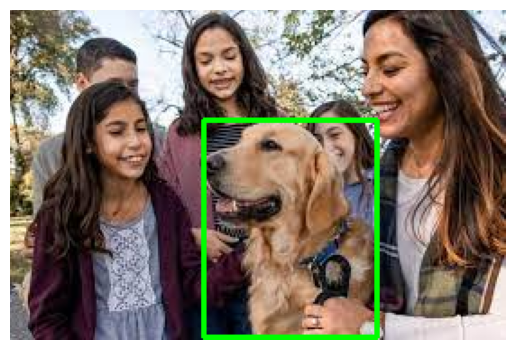

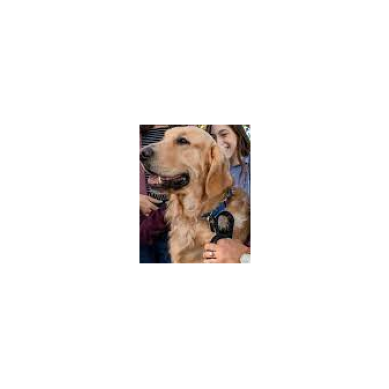

In [89]:
import cv2
import os
import numpy as np
from ultralytics import YOLO    
import matplotlib.pyplot as plt
# Function to load the YOLOv8 model
def load_yolov8_model():
    model = YOLO("yolov8n.pt")  # Load using YOLO class from ultralytics
    return model

# Function to detect dogs and process image
def detect_and_process_dog(image_path, output_folder, dog_class_id=0, fixed_crop_size=(320, 320)):
    # Load image
    image = cv2.imread(image_path)
    imagecopy = image.copy()
    # Load YOLOv8 model
    model = load_yolov8_model()

    # Perform object detection
    results = model(image, classes=[16])
    isDog = False
    
    if len(results[0]) > 0:
        isDog = True
        result = results[0]
        box = result.boxes

        # Draw rectangle on original image
        for i in range(len(box)):
            newBox = box[i]
            prob = newBox.conf[i].item()
            print("Probability: ", prob)
            if prob > 0.2:  # Consider only if probability is greater than 0.5
                x1, y1, x2, y2 = newBox.xyxy[0]
                cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                
                # cropped_image = imagecopy[int(y1):int(y2), int(x1):int(x2)]
                
                # Calculate dimensions for cropping
                width = int(x2 - x1)
                height = int(y2 - y1)
                center_x = int((x1 + x2) / 2)
                center_y = int((y1 + y2) / 2)

                # Calculate crop region
                crop_x1 = max(0, center_x - width // 2)
                crop_y1 = max(0, center_y - height // 2)
                crop_x2 = min(image.shape[1], crop_x1 + width)
                crop_y2 = min(image.shape[0], crop_y1 + height)

                # Extract the region and pad it to the fixed size
                cropped_image = imagecopy[crop_y1:crop_y2, crop_x1:crop_x2]
                padded_image = np.full((fixed_crop_size[1], fixed_crop_size[0], 3), 255, dtype=np.uint8)

                # Calculate position for pasting the cropped image
                paste_x1 = (fixed_crop_size[0] - width) // 2
                paste_y1 = (fixed_crop_size[1] - height) // 2
                paste_x2 = paste_x1 + width
                paste_y2 = paste_y1 + height

                # Paste the cropped image onto the padded canvas
                padded_image[paste_y1:paste_y2, paste_x1:paste_x2] = cropped_image

                # Save the padded image to the output folder
                filename = os.path.basename(image_path)
                cropped_image_path = os.path.join(output_folder, filename)
                cv2.imwrite(cropped_image_path, padded_image)

        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    if isDog:
        return True, padded_image
    else:
        return False, None

# usage
image_path = "Dog_images/2.jpeg"  
output_folder = "output_images"

isDog, img = detect_and_process_dog(image_path, output_folder)
if isDog:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()